# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation

We then can train our network using the iref or CPDB PPI together with the multi-omics information.

In [1]:
# classics
import sys, os
import pandas as pd
import numpy as np

# embeddings
from sklearn import preprocessing
from sklearn.decomposition import PCA
import umap

# own code
import preprocessing_utils as utils
sys.path.append(os.path.abspath('../../GCN'))
import gcnPreprocessing
import gcnIO

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Parameters
* `use_quantile_norm`: Normalize the data with (normal) quantile normalization instead of simple MinMax normalization
* `ppi_network_to_use`: Which underlying PPI network to use (can be [CPDB](http://cpdb.molgen.mpg.de/CPDB), [IREF](http://irefindex.org/wiki/index.php?title=iRefIndex) , Multinet, [STRING](https://string-db.org/) or [PCNet](https://www.sciencedirect.com/science/article/pii/S2405471218300954))
* `remove_blood_cancer_genes`: Whether or not to remove blood cancer genes according to [COSMIC CGC](https://cancer.sanger.ac.uk/cosmic/download) from the positive labels (known cancer genes) or not (True for removal, False otherwise)
* `cna_as_separate_omics`: Whether or not copy number changes (as determined by GISTIC 2) are added to the SNV information or treated as separate data set
* `use_mutsigcv_scores`: Uses the $-log_{10}$ q-values from MutSigCV instead of the simple counts of SNVs per gene
* `label_source`: Which source to use for the positive labels (known cancer genes). This can come from either the [NCG](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1612-0) or a literature mining approach called [DigSEE](http://210.107.182.61/digseeOld/). While the NCG known cancer genes represent a manually curated list with pan-cancer genes, this source is highly biased to over-studied genes and mutations. DigSEE genes, on the other hand, are only mined from PubMed abstracts and therefore much less reliable but on the other hand less biased. DigSEE enables to look for the evidence that leads to a cancer and therefore options for this variable are: _NCG_, _expression_, _methylation_, _mutation_
* `use_cnas`: Whether or not to integrate copy number information in the data (either as separate -omics or added to the SNVs similar to HotNet2, determined by `cna_as_separate_omics`)

In [2]:
# PARAMETERS
use_quantile_norm = False # quantile or MinMax normalization
ppi_network_to_use ='CPDB'
remove_blood_cancer_genes = False
cna_as_separate_omics = False
use_mutsigcv_scores = False
use_cnas = True
label_source = 'all'
minimum_degree_negatives = 1
patient_wise = False

## Load the data from disk and unify

In [3]:
trim_to_submitter = lambda x: '-'.join(str(x).split('-')[:3]) # TCGA barcode until patient

if patient_wise:
    # load mutation data
    matrix_name = 'snv_cna_sample_matrix' if use_cnas else 'snv_sample_matrix'
    mutfreqs_patients = pd.read_hdf('../../data/pancancer/TCGA/mutation/mutation_frequencies_lengthnormalized.h5', matrix_name).T
    mutfreqs_patients.index = mutfreqs_patients.index.map(trim_to_submitter)
    mutation_features = mutfreqs_patients.T
    
    # load methylation data
    meth_samples = pd.read_hdf('../../data/pancancer/TCGA/methylation/sample_matrix_foldchanges.h5', 'methylation_sample_matrix').T
    meth_samples['Cancer_Type'] = [i[1] for i in meth_samples.index.str.split('|')]
    meth_features = meth_samples.T.drop('Cancer_Type', axis=0)
    meth_features.columns = [i.split('|')[0].strip() for i in meth_features.columns] # remove everything but the TCGA barcode
    meth_features.columns = meth_features.columns.map(trim_to_submitter) # remove parts of barcode that no longer describe the patient (submitter)
    
    # load gene expression data
    ge_samples = pd.read_hdf('../../data/pancancer/TCGA/expression/sample_matrix_fc_gtex.h5').T
    ge_samples.index = ge_samples.index.map(trim_to_submitter)
    expr_features = ge_samples.T
    
    fig = plt.figure(figsize=(14, 8))
    v = matplotlib_venn.venn3([set(expr_features.columns), set(mutation_features.columns), set(meth_features.columns)],
                              set_labels=["Expression", "Mutation", "Methylation"])
    if not v.get_patch_by_id('10') is None:
        v.get_patch_by_id('10').set_color('#3d3e3d')
        v.get_label_by_id('10').set_fontsize(20)
    if not v.get_patch_by_id('11') is None:
        v.get_patch_by_id('11').set_color('#37652d')
        v.get_label_by_id('11').set_fontsize(20)
    v.get_patch_by_id('011').set_color('#4d2600')
    v.get_label_by_id('A').set_fontsize(20)
    v.get_label_by_id('B').set_fontsize(20)
    v.get_label_by_id('C').set_fontsize(20)
    if not v.get_patch_by_id('01') is None:
        v.get_patch_by_id('01').set_color('#ee7600')
        v.get_label_by_id('01').set_fontsize(20)
    if not v.get_patch_by_id('111') is None and not v.get_patch_by_id('101') is None:
        v.get_label_by_id('111').set_fontsize(20)
        v.get_label_by_id('101').set_fontsize(20)
        v.get_patch_by_id('111').set_color('#890707')
        v.get_patch_by_id('101').set_color('#6E80B7')
    if not v.get_patch_by_id('011') is None:
        v.get_label_by_id('011').set_fontsize(20)
    if not v.get_patch_by_id('001') is None:
        v.get_patch_by_id('001').set_color('#031F6F')
        v.get_label_by_id('001').set_fontsize(20)
    common_samples = list(set(expr_features.columns).intersection(mutation_features.columns).intersection(meth_features.columns))
    
    # load the PPI network
    ppi_network = utils.load_PPI_network(network_name=ppi_network_to_use)

    # decide on normalization method
    if use_quantile_norm:
        scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    else:
        scaler = preprocessing.MinMaxScaler()

    all_omics_normed = []
    all_omics_raw = []
    for feat in [mutation_features, meth_features, expr_features]:
        feat_avg_samples = feat.astype(np.float32).groupby(level=0, axis=1).mean() # average same patient's samples
        print ("{} genes are in network and feature".format(feat_avg_samples.index.isin(ppi_network.index).sum()))
        feat_ppiindex = feat_avg_samples.reindex(ppi_network.index, fill_value=0) # reindex to match with PPI nodes
        feat_common = feat_ppiindex[common_samples]
        feat_normed = scaler.fit_transform(feat_common) # normalize
        all_omics_normed.append(feat_normed)
        all_omics_raw.append(feat_common.values)
        print (feat_normed.shape, feat_common.shape)

    multi_omics_features = np.array(all_omics_normed)
    multi_omics_features = np.transpose(multi_omics_features, (1, 2, 0))
    multi_omics_features_raw = np.array(all_omics_raw)
    multi_omics_features_raw = np.transpose(multi_omics_features, (1, 2, 0))
    multi_omics_features.shape
    feat_names_all = common_samples
    
    
else:
    # Load mutation data
    if use_mutsigcv_scores:
        snvs = pd.read_csv('../../data/pancancer/mutsigcv/mutsigcv_genescores.csv', sep='\t')
        snvs.columns = ['Name'] + snvs.columns.tolist()[1:]
        snvs.set_index('Name', inplace=True)
    else:
        if use_cnas and not cna_as_separate_omics:
            snvs = pd.read_csv('../../data/pancancer/TCGA/mutation/mutfreq_mean.tsv', sep='\t')
        else:
            snvs = pd.read_csv('../../data/pancancer/TCGA/mutation/snvs_mean.tsv', sep='\t')
        snvs.columns = ['Name'] + snvs.columns[1:].tolist()
        snvs.set_index('Name', inplace=True)
        #snvs.set_index('Name', inplace=True)
        #snvs.columns = ['Ensembl_ID'] + snvs.columns[1:].tolist()

    # Load methylation
    methylation = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_RATIO_mean.tsv', sep='\t')
    methylation.columns = ['Name'] + [i.upper() for i in methylation.columns[1:]]
    methylation.set_index('Name', inplace=True)

    # Load expression
    expression = pd.read_csv('../../data/pancancer/TCGA/expression/expression_fixed_mean.tsv', sep='\t')
    #expression = pd.read_csv('../../data/pancancer/TCGA/expression/expression_mean_counts_gtexnormal.tsv', sep='\t')
    expression.columns = ['Name'] + [i.upper() for i in expression.columns[1:]]
    expression.set_index('Name', inplace=True)

    # load CNAs
    cnas = pd.read_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_meancancertypes_20160128.tsv', sep='\t')
    cnas.columns = ['Name'] + [i.upper() for i in cnas.columns[1:]]
    cnas.set_index('Name', inplace=True)

    # Load PPI network
    ppi_network = utils.load_PPI_network(network_name=ppi_network_to_use)

    # Next, I have to remove cancer types only present in a subset of the data
    relevant_ctypes = list(set(snvs.columns[1:]).intersection(*[set(expression.columns), set(methylation.columns), set(cnas.columns)]))
    snvs = snvs[relevant_ctypes]
    methylation = methylation[relevant_ctypes]
    expression = expression[relevant_ctypes]
    cnas = cnas[relevant_ctypes]

    # Finally, reindex to the network nodes such that everything is in the same order and non-network genes are removed
    snvs_ppiindex = snvs.reindex(ppi_network.index, fill_value=0)
    methylation_ppiindex = methylation.reindex(ppi_network.index, fill_value=0)
    expression_ppiindex = expression.reindex(ppi_network.index, fill_value=0)
    cna_ppiindex = cnas.reindex(ppi_network.index, fill_value=0)

    # print some stats
    mut_nodes = snvs[snvs.index.isin(ppi_network.index)].shape[0]
    meth_nodes = methylation[methylation.index.isin(ppi_network.index)].shape[0]
    ge_nodes = expression[expression.index.isin(ppi_network.index)].shape[0]
    cna_nodes = cnas[cnas.index.isin(ppi_network.index)].shape[0]
    print ("Network has {} nodes/genes".format(ppi_network.shape[0]))
    print ("* {} genes in network have mutations".format(mut_nodes))
    print ("* {}  genes in network have methylation data".format(meth_nodes))
    print ("* {} genes in network have gene expression".format(ge_nodes))
    print ("* {} genes in network have CNA information".format(cna_nodes))

Network has 13627 nodes/genes
* 13097 genes in network have mutations
* 12406  genes in network have methylation data
* 12898 genes in network have gene expression
* 12088 genes in network have CNA information


In [4]:
if not patient_wise:
    # verify that the genes are the same and that they are in the same order
    print ((snvs_ppiindex.index == methylation_ppiindex.index).all())
    print ((snvs_ppiindex.index == expression_ppiindex.index).all())
    print ((methylation_ppiindex.index == expression_ppiindex.index).all())
    print ((snvs_ppiindex.index == ppi_network.index).all())
    print ((cna_ppiindex.index == ppi_network.index).all())

True
True
True
True
True


## Join Multi-Omics to form one feature matrix

In [5]:
if not patient_wise:
    if use_quantile_norm:
        scaler = preprocessing.QuantileTransformer(output_distribution='normal')
        #scaler = preprocessing.StandardScaler()
        ge_norm = preprocessing.MinMaxScaler().fit_transform(np.abs(scaler.fit_transform(expression_ppiindex)))
        mutfreq_norm = preprocessing.MinMaxScaler().fit_transform(snvs_ppiindex)
        #mutfreq_norm = preprocessing.MinMaxScaler().fit_transform(mutations_ppiindex)
        meth_norm = preprocessing.MinMaxScaler().fit_transform(np.abs(scaler.fit_transform(methylation_ppiindex)))
        cna_norm = preprocessing.MinMaxScaler().fit_transform(np.abs(scaler.fit_transform(cna_ppiindex)))
    else:
        scaler = preprocessing.MinMaxScaler()
        ge_norm = scaler.fit_transform(np.abs(expression_ppiindex))
        mutfreq_norm = scaler.fit_transform(snvs_ppiindex)
        meth_norm = scaler.fit_transform(np.abs(methylation_ppiindex))
        cna_norm = scaler.fit_transform(np.abs(cna_ppiindex))

    if cna_as_separate_omics:
        multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm, cna_norm), axis=1)
        multi_omics_features_raw = np.concatenate((snvs_ppiindex, methylation_ppiindex, expression_ppiindex, cna_ppiindex), axis=1)
    else:
        multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
        multi_omics_features_raw = np.concatenate((snvs_ppiindex, methylation_ppiindex, expression_ppiindex), axis=1)

In [6]:
#np.save('../../data/pancancer/multiomics_features_raw.npy', multi_omics_features_raw)
#np.save('../../data/pancancer/multiomics_features.npy', multi_omics_features)

### Plot Distribution of Features

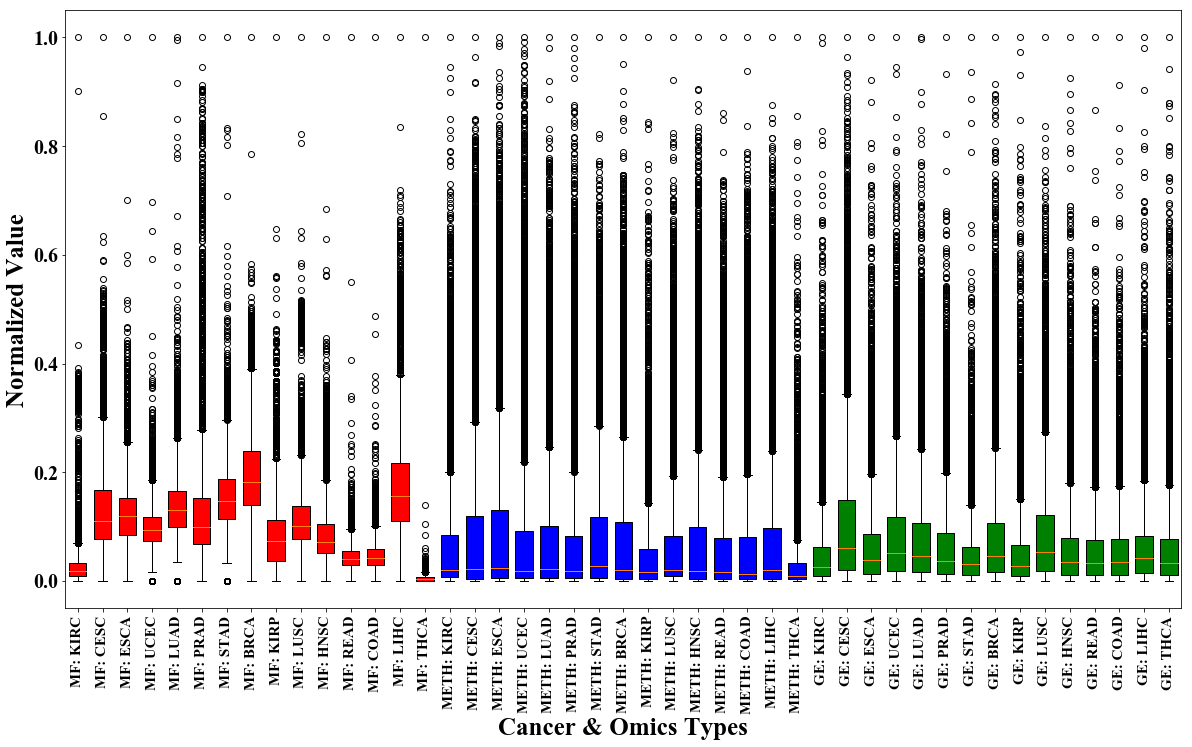

In [7]:
if not patient_wise:
    # plot distribution of features
    fig = plt.figure(figsize=(20, 11))

    # mutation frequencies
    feat_names_mut = ['MF: ' + i.upper() for i in snvs_ppiindex.columns]

    # gene expression
    feat_names_ge = ['GE: ' + i.upper() for i in expression_ppiindex.columns]

    # methylation
    feat_names_meth = ['METH: ' + i.upper() for i in methylation_ppiindex.columns]

    # CNAs
    if cna_as_separate_omics:
        feat_names_cna = ['CNA: ' + i.upper() for i in cna_ppiindex.columns]
        feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge + feat_names_cna
    else:
        feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

    # plot
    x = plt.boxplot(multi_omics_features, widths=0.7, patch_artist=True)
    _ = plt.xticks(range(1, multi_omics_features.shape[1]+1), feat_names_all, rotation='vertical', fontsize=15)
    _ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

    # fill with colors
    colors = ['red']*len(feat_names_mut) + ['blue']*len(feat_names_meth) + ['green']*len(feat_names_ge) + ['orange']*len(feat_names_ge)
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)

    #plt.gca().set_ylim([-2, 2])
    plt.xlabel('Cancer & Omics Types', fontsize=25)
    plt.ylabel('Normalized Value', fontsize=25)
    #plt.title('Distribution of Multi-Omics Data', fontsize=30)

    #if use_quantile_norm:
    #    fig.savefig('multi_omics_feature_distribution_quantiled.png', dpi=300)
    #else:
    #    fig.savefig('multi_omics_feature_distribution_normminmax.png', dpi=300)

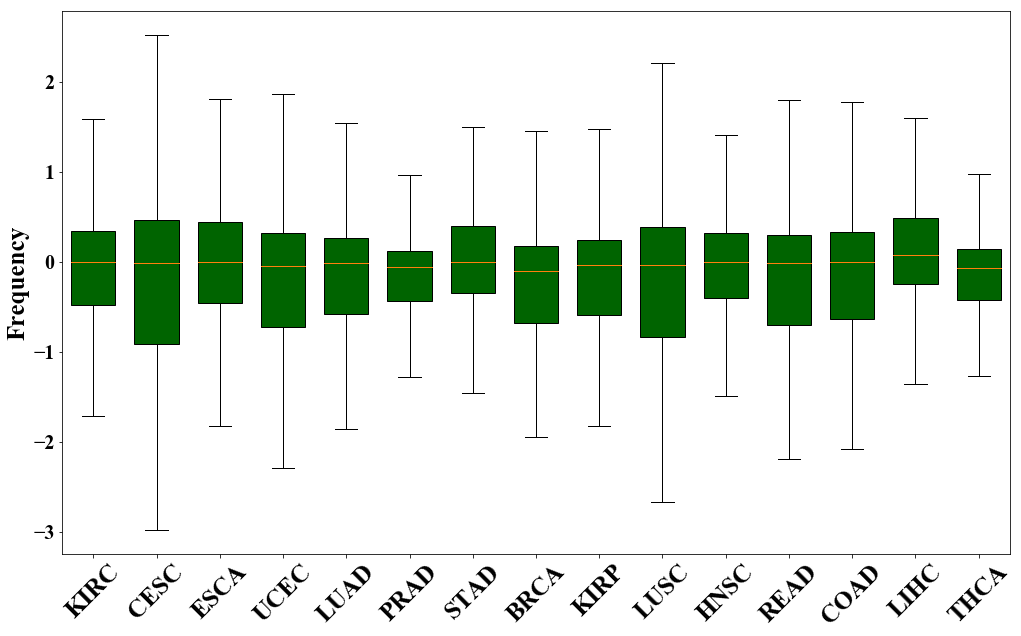

In [8]:
if not patient_wise:
    fig = plt.figure(figsize=(17, 10))

    # plot
    x = plt.boxplot(expression_ppiindex.values, widths=0.7, patch_artist=True, showfliers=False)
    _ = plt.xticks(range(1, expression_ppiindex.shape[1]+1), [i.upper() for i in expression_ppiindex.columns], rotation=45, fontsize=25)
    _ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

    colors = ['darkgreen']*len(feat_names_ge)
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)

    #plt.gca().set_ylim([-0.05, 2])
    #plt.gca().set_ylim([-0.005, .07])
    plt.xlabel('', fontsize=25)
    #plt.ylabel('Frequency', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    #plt.title('Distribution of Multi-Omics Data', fontsize=30)
    fig.savefig('../../plots/input_ge.svg')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

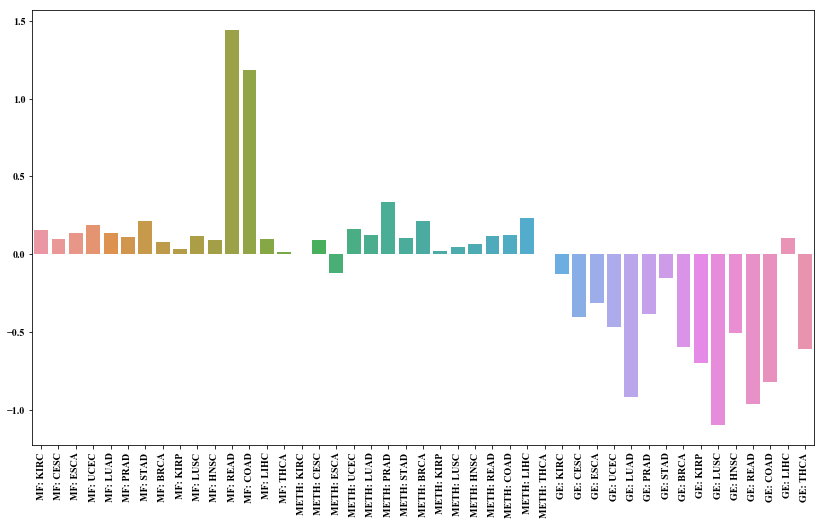

In [49]:
fig = plt.figure(figsize=(14, 8))
multi_omics_df = pd.DataFrame(multi_omics_features_raw, index=ppi_network.index, columns=feat_names_all)
sns.barplot(x=list(range(45)), y=multi_omics_df[multi_omics_df.index == 'APC'].values.reshape(-1))
plt.gca().set_xticklabels(multi_omics_df.columns)
plt.xticks(rotation=90)

Text(0, 0.5, 'Component 2')

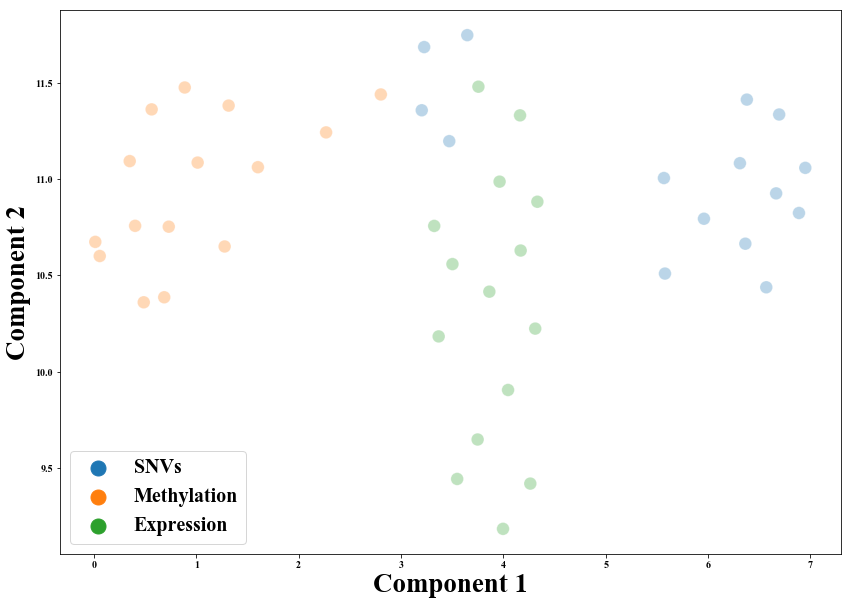

In [28]:
dim_red = umap.UMAP(n_components=2)

if len(multi_omics_features.shape) == 3:
    feat = multi_omics_features.reshape(multi_omics_features.shape[0], -1).T
else:
    feat = multi_omics_features.T
emb = dim_red.fit_transform(feat)
fig = plt.figure(figsize=(14, 10))
if cna_as_separate_omics and not patient_wise:
    cols = ['SNVs']*len(feat_names_mut) + ['Methylation']*len(feat_names_meth) + \
           ['Expression']*len(feat_names_ge) + ['CNAs']*len(feat_names_cna)
elif not patient_wise:
    cols = ['SNVs']*len(feat_names_mut) + ['Methylation']*len(feat_names_meth) + \
       ['Expression']*len(feat_names_ge)
else:
    cols= ['SNVs']*multi_omics_features.shape[1] + ['Methylation']*multi_omics_features.shape[1] + \
          ['Expression']*multi_omics_features.shape[1]
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], s=160, hue=cols, alpha=.3)
legend = plt.legend(prop={'size': 20}, markerscale=2.5)
plt.xlabel('Component 1', fontsize=27)
plt.ylabel('Component 2', fontsize=27)

### Correlation Matrix between Features

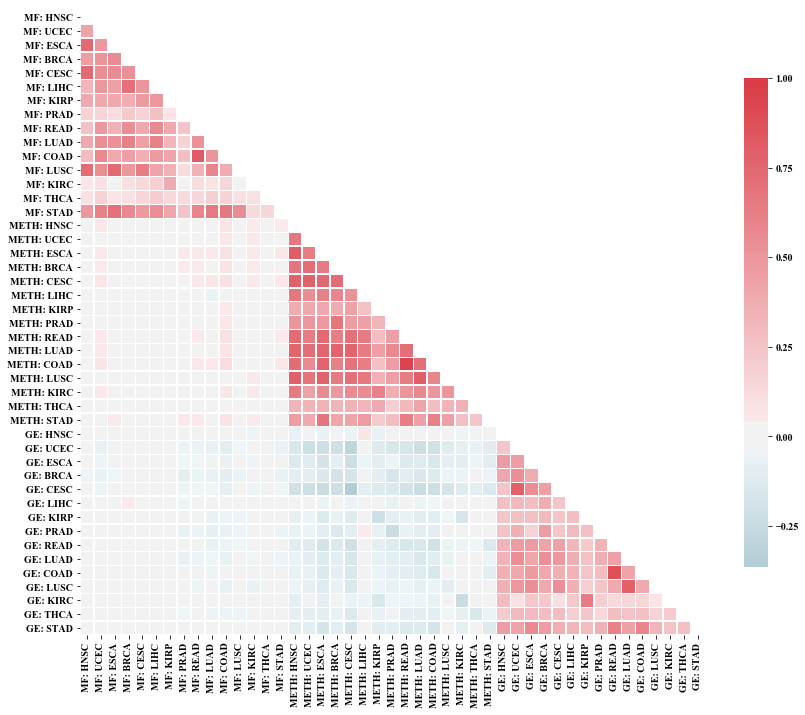

In [29]:
if not patient_wise:
    corr = pd.DataFrame(multi_omics_features_raw, index=ppi_network.index, columns=feat_names_all).corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.color_palette("coolwarm")

    # Draw the heatmap with the mask and correct aspect ratio
    _ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, xticklabels=True, yticklabels=True, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
    f.savefig('../../data/pancancer/TCGA/feature_correlation.svg')

## Get Labels

In [32]:
nodes = utils.get_ensembl_from_symbol(ppi_network.index)
nodes.head()
nodes.columns = ['Name']

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13627...done.
Finished.
19 input query terms found dup hits:
	[('TEC', 2), ('IGHM', 3), ('TCP10', 2), ('MEMO1', 2), ('KCNA6', 2), ('MMD2', 2), ('HBD', 2), ('IGKV3
155 input query terms found no hit:
	['TMEM173', 'EPRS', 'SEPT1', 'HIST3H3', 'AES', 'H3F3A', 'H3F3B', 'QARS', 'HIST1H2AE', 'HIST1H2AB', '


In [33]:
known_cancer_genes_innet = utils.get_positive_labels(nodes,
                                                     strategy=label_source,
                                                     cancer_type='pancancer',
                                                     remove_blood_cancer_genes=remove_blood_cancer_genes,
                                                     verbose=True
                                                    )

Collected 796 cancer genes with strategy all


In [34]:
negatives = utils.get_negative_labels(nodes, known_cancer_genes_innet, ppi_network, min_degree=minimum_degree_negatives, verbose=True)

13627 genes are in network
12831 genes are in network but not in positives (known cancer genes from NCG)
12810 genes are also not in OMIM cancer genes
2344 genes are in network but not in oncogenes and not in OMIM
2344 genes are also not in COSMIC cancer gene census
2344 genes are also not in COSMIC mutated genes
2341 genes are also not in KEGG cancer pathways
2187 genes are also not in NCG candidate cancer genes
2187 genes have a degree >= 1.


91.52763819095478 23.313671696387747


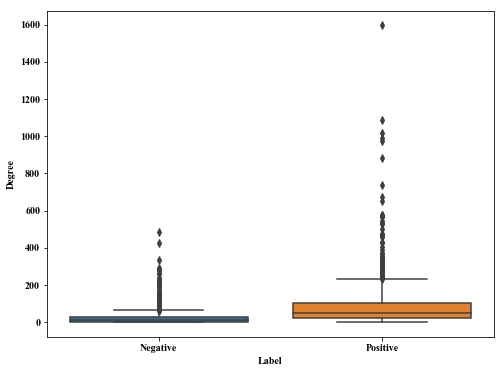

In [35]:
degrees_with_labels = pd.DataFrame(ppi_network.sum(), columns=['Degree'])
degrees_with_labels['Label'] = 'Unknown'
degrees_with_labels.loc[degrees_with_labels.index.isin(known_cancer_genes_innet), 'Label'] = 'Positive'
degrees_with_labels.loc[degrees_with_labels.index.isin(negatives.Name), 'Label'] = 'Negative'

fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=degrees_with_labels[degrees_with_labels.Label.isin(['Positive', 'Negative'])],
            x='Label', y='Degree')
#plt.ylim([-5, 300])
print (degrees_with_labels[degrees_with_labels.index.isin(known_cancer_genes_innet)].Degree.mean(), degrees_with_labels[degrees_with_labels.index.isin(negatives.Name)].Degree.mean())

0.010925661579005161


/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


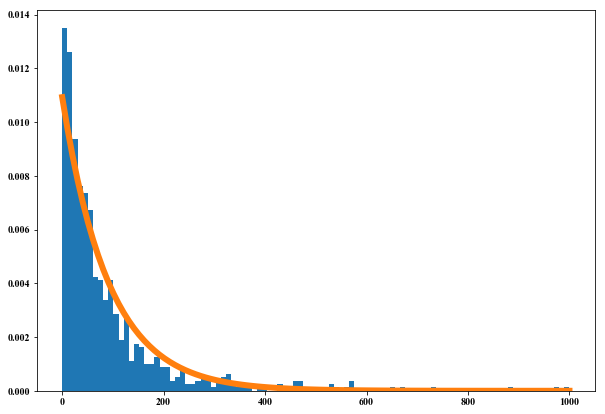

In [36]:
from scipy.stats import expon
fig = plt.figure(figsize=(10, 7))
x = np.linspace(0, 1000, 100)
pos_degrees = degrees_with_labels[degrees_with_labels.Label == 'Positive'].Degree
_ = plt.hist(pos_degrees, bins=x, normed=True)
lam = 1./pos_degrees.mean()
eta = 0.01
print (lam)
plt.plot(x, lam * np.exp(-lam*x), lw=6)

In [37]:
all_negs = degrees_with_labels[degrees_with_labels.index.isin(negatives.Name)]
density_for_negs = lam * np.exp(-lam*all_negs.Degree) + 0.005
density_for_negs.sort_values(ascending=True).head(10)

SNW1      0.005054
YWHAQ     0.005102
SRPK2     0.005284
H2AFX     0.005455
HNRNPM    0.005485
EIF4A3    0.005507
ILF2      0.005518
HNRNPD    0.005611
MAPK6     0.005638
RACK1     0.005802
Name: Degree, dtype: float64

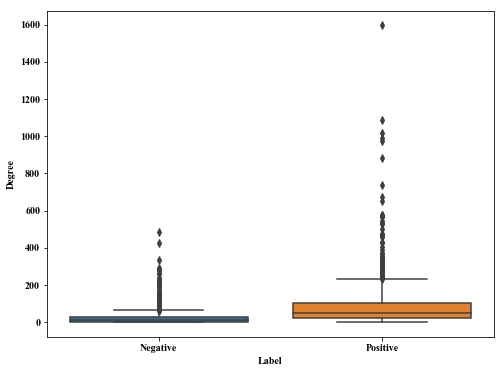

In [38]:
negs = all_negs.sample(n=10, weights=density_for_negs)
to_plot = degrees_with_labels.copy()
to_plot.loc[to_plot.index.isin(known_cancer_genes_innet), 'Label'] = 'Positive'
to_plot.loc[to_plot.index.isin(negs.index), 'Label'] = 'Sampled Negatives'
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=degrees_with_labels[degrees_with_labels.Label.isin(['Positive', 'Negative', 'Sampled Negative'])],
            x='Label', y='Degree')

In [39]:
negs.Degree.mean(), pos_degrees.mean(), degrees_with_labels[degrees_with_labels.Label == 'Negative'].Degree.mean()

(13.0, 91.52763819095478, 23.313671696387747)

## Do Training and Test Split

In [40]:
y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)

In [41]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.sum(), train_mask.sum(), y_test.sum(), test_mask.sum(), y_val.sum(), val_mask.sum()

(537, 2013, 199, 746, 60, 224)

## Write back everything to container

In [42]:
nodes['ID'] = nodes.index
nodes = nodes[['ID', 'Name']]

fname = '../../data/pancancer/{}_multiomics_TCGACNAs.h5'.format(ppi_network_to_use.upper())
utils.write_hdf5_container(fname, ppi_network.values, multi_omics_features, nodes, y_train,
                           y_val, y_test, train_mask, val_mask, test_mask, feat_names_all,
                           multi_omics_features_raw
                          )

Container written to ../../data/pancancer/CPDB_multiomics_TCGACNAs.h5


## Write containers for leave-one-out omics
These are HDF5 containers in which one of the data types was left out.

In [33]:
if cna_as_separate_omics:
    # write data without SNVs
    no_snv_features = np.concatenate((meth_norm, ge_norm, cna_norm), axis=1)
    fname = '../../data/pancancer/{}_no_snvs.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, no_snv_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_meth + feat_names_ge + feat_names_cna,
                               np.concatenate((methylation_ppiindex, expression_ppiindex, cna_ppiindex), axis=1)
                              )
    
    # write data without methylation
    no_meth_features = np.concatenate((mutfreq_norm, ge_norm, cna_norm), axis=1)
    fname = '../../data/pancancer/{}_no_meth.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, no_meth_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_mut + feat_names_ge + feat_names_cna,
                               np.concatenate((snvs_ppiindex, expression_ppiindex, cna_ppiindex), axis=1)
                              )
    
    # write data without gene expression
    no_ge_features = np.concatenate((mutfreq_norm, meth_norm, cna_norm), axis=1)
    fname = '../../data/pancancer/{}_no_ge.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, no_ge_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_mut + feat_names_meth + feat_names_cna,
                               np.concatenate((snvs_ppiindex, methylation_ppiindex, cna_ppiindex), axis=1)
                              )
    
    # write data without CNA
    no_cna_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
    fname = '../../data/pancancer/{}_no_cna.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, no_cna_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_mut + feat_names_meth + feat_names_ge,
                               np.concatenate((snvs_ppiindex, methylation_ppiindex, expression_ppiindex), axis=1)
                              )
else:
    # write methylation + expression data
    meth_ge_features = np.concatenate((meth_norm, ge_norm), axis=1)
    fname = '../../data/pancancer/{}_methylation_expression.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, meth_ge_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_meth + feat_names_ge,
                               np.concatenate((methylation_ppiindex, expression_ppiindex), axis=1)
                              )
    
    # write methylation + mutation data (SNV and or CNA)
    meth_mutfreq_features = np.concatenate((meth_norm, mutfreq_norm), axis=1)
    fname = '../../data/pancancer/{}_methylation_mutation.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, meth_mutfreq_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_meth + feat_names_mut,
                               np.concatenate((methylation_ppiindex, snvs_ppiindex), axis=1)
                              )
    
    # write mutation (SNV and/or CNA) + expression data
    mutfreq_ge_features = np.concatenate((mutfreq_norm, ge_norm), axis=1)
    fname = '../../data/pancancer/{}_mutation_expression.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, mutfreq_ge_features, nodes,
                               y_train, y_val, y_test, train_mask, val_mask, test_mask,
                               feat_names_mut + feat_names_ge,
                               np.concatenate((snvs_ppiindex, expression_ppiindex), axis=1)
                              )

Container written to ../../data/pancancer/PCNET_methylation_expression.h5
Container written to ../../data/pancancer/PCNET_methylation_mutation.h5
Container written to ../../data/pancancer/PCNET_mutation_expression.h5


## Write out single omics combinations

In [34]:
fname = '../../data/pancancer/{}_mutations.h5'.format(ppi_network_to_use.upper())
utils.write_hdf5_container(fname, ppi_network.values, mutfreq_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_mut, snvs_ppiindex)

Container written to ../../data/pancancer/PCNET_mutations.h5


In [35]:
fname = '../../data/pancancer/{}_methylation.h5'.format(ppi_network_to_use.upper())
utils.write_hdf5_container(fname, ppi_network.values, meth_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_meth, methylation_ppiindex)

Container written to ../../data/pancancer/PCNET_methylation.h5


In [36]:
fname = '../../data/pancancer/{}_expression.h5'.format(ppi_network_to_use.upper())
utils.write_hdf5_container(fname, ppi_network.values, ge_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_ge, expression_ppiindex)

Container written to ../../data/pancancer/PCNET_expression.h5


In [37]:
if cna_as_separate_omics:
    fname = '../../data/pancancer/{}_cnas.h5'.format(ppi_network_to_use.upper())
    utils.write_hdf5_container(fname, ppi_network.values, cna_norm, nodes, y_train,
                         y_val, y_test, train_mask, val_mask, test_mask, feat_names_cna, cna_ppiindex)